In [1]:
import json
import os

import cv2
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import rgb2gray
import torch
from torch.utils.data import Dataset, DataLoader 
import random 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time

## Some utilities

In [2]:
BASE = "/srv/data/lt2326-h25/lt2326-h25/a1"
IMG_DIR = os.path.join(BASE, "images")
TRAIN_JSONL = os.path.join(BASE, "train.jsonl")

# Costants of the datasset
IMG_HEIGHT = 2048
IMG_WIDTH = 2048
IMG_CHANNELS = 3

# Function for reading json files
def read_jsonl(path):
    """Read a .jsonl (JSON Lines) file and return a list of JSON objects."""
    anns = []
    try:
        with open(path, "r") as f:
            for line in f:
                line = line.strip()
                if line:
                    anns.append(json.loads(line))
    except FileNotFoundError:
        print(f"WARNING: File not found: {path}")
    return anns


# Function to create the mask from the given polygon properties
def rasterize_polygon_mask(h, w, polygons):
    # Initialize an empty mask filled with zeros (background)
    mask = np.zeros((h, w), dtype=np.uint8)
    if not polygons:
        return mask
    
    # Convert each polygon into the format required by cv2.fillPoly:
    # - Convert to float32, then round to nearest int
    # - Cast to int32
    # - Reshape into shape (N, 1, 2) as expected by OpenCV
    pts = [np.round(np.array(p, dtype=np.float32)).astype(np.int32).reshape(-1, 1, 2) for p in polygons]

    # Fill the polygons on the mask with value 1 (foreground)
    cv2.fillPoly(
        mask,
        pts=pts,
        color=1  # Set the color for the region
    )
    return mask

## Dataset with initialization for every polygon of every chinese character

In [3]:
# Target Images size for shrinking
TARGET_IMG_HEIGHT = 512
TARGET_IMG_WIDTH = 512

class ImageMaskDataset(Dataset):
    """
    Dataset with lazy loading and integrated resizing.
    Loads a high-res image (e.g., 2048x2048), rasterizes polygon labels
    at the ORIGINAL resolution, then downsamples to the target size
    (defaults: 1024 x 1024).
    Returns (image_tensor, mask_tensor).
    """
    
    def __init__(self, metadata_list, target_h=TARGET_IMG_HEIGHT, target_w=TARGET_IMG_WIDTH):
        self.metadata = metadata_list
        self.TH = target_h
        self.TW = target_w
        self.IMG_CHANNELS = 3

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        # ---- LOAD IMAGE AT ORIGINAL RESOLUTION ----
        anno = self.metadata[idx]

        # Read BGR image; raise if missing or unreadable
        img = cv2.imread(anno["file_path"], cv2.IMREAD_COLOR)
        if img is None:
             raise RuntimeError(f"Failed to read image: {anno['file_path']}")

        # Convert BGR to RGB and copy to ensure a contiguous array
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        chinese_polys, ignore_polys = [], []
        # Extract polygons marked as chinese (or default True)
        # Expected structure: anno["annotations"] is a list of textlines,
        # each textline is a list of instances (dicts)
        for textline in anno["annotations"]:
            for inst in textline:
                poly = inst.get("polygon")
                if poly and len(poly) >= 3 and inst.get("is_chinese", True):
                    chinese_polys.append(poly)

        # Polygons to ignore (will be subtracted from the final mask)
        for ign in anno["ignore"]:
            poly = ign.get("polygon")
            if poly and len(poly) >= 3:
                ignore_polys.append(poly)
                
        # ---- RASTERIZE MASKS AT ORIGINAL SIZE ----
        H_orig, W_orig = img.shape[:2]
        chinese_mask = rasterize_polygon_mask(H_orig, W_orig, chinese_polys)
        ignore_mask = rasterize_polygon_mask(H_orig, W_orig, ignore_polys)

        # Keep pixels that are chinese AND NOT ignored
        # final_mask is boolean; cast to uint8 {0,1}
        final_mask = (chinese_mask == 1) & (ignore_mask == 0)
        mask_orig = final_mask.astype(np.uint8) 
        
        # ---- RESIZE TO TARGET SIZE ----
        # Image: use AREA for high-quality downsampling
        if (H_orig, W_orig) != (self.TH, self.TW):
            image_resized = cv2.resize(img, (self.TW, self.TH), interpolation=cv2.INTER_AREA)
        else:
            image_resized = img

         # Mask: use NEAREST to preserve crisp class boundaries and small glyphs (interpolation)
        if (H_orig, W_orig) != (self.TH, self.TW):
            mask_resized = cv2.resize(mask_orig, (self.TW, self.TH), interpolation=cv2.INTER_NEAREST)
        else:
            mask_resized = mask_orig
            
        # ---- CONVERT TO PYTORCH TENSORS ----
        # Image: HWC -> CHW, float32 in [0,1]
        image = image_resized[:, :, :self.IMG_CHANNELS]
        image = np.transpose(image, (2, 0, 1)) 
        image = image.astype(np.float32) / 255.0
        image_tensor = torch.from_numpy(image)
        
        # Mask: shape from (H, W) to (1, H, W), float32 in {0.0, 1.0}
        mask_tensor = torch.from_numpy(mask_resized[np.newaxis, :, :].astype(np.float32))
            
        return image_tensor, mask_tensor

## SegNet structure

In [4]:
class SimpleSegNet(nn.Module):
    """
    A compact SegNet-style encoder–decoder for semantic segmentation.

    Notes:
    - This model returns **logits** by default (no final activation). 
      Apply `torch.sigmoid` (binary) or `torch.softmax` (multi-class) outside.
    """
    def __init__(self, in_channels=3, out_channels=1):
        super(SimpleSegNet, self).__init__()
        
        # --- ENCODER (reduced channels) ---
        self.enc1 = self._make_encoder_block(in_channels, 32)
        self.enc2 = self._make_encoder_block(32, 64)
        self.enc3 = self._make_encoder_block(64, 128)
        
         # Block 4 (bottleneck): 128 -> 128, no pooling here
        self.enc4 = self._make_encoder_block(128, 128, final_block=True) 
        
        
        # --- DECODER (mirrored, reduced channels) ---
        self.dec4 = self._make_decoder_block(128, 64) 
        self.dec3 = self._make_decoder_block(64, 32)
        self.dec2 = self._make_decoder_block(32, 16)
        
        # Final conv: 16 -> out_channels (no BN/ReLU)
        self.dec1 = self._make_decoder_block(16, out_channels, final_layer=True)


    def _make_encoder_block(self, in_c, out_c, kernel_size=3, padding=1, final_block=False):
        """Standard encoder block: (Conv-BN-ReLU) x 2."""
        return nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True)
        )

    def _make_decoder_block(self, in_c, out_c, kernel_size=3, padding=1, final_layer=False):
         """
        Standard decoder block.
        - For intermediate blocks we keep a (Conv-BN-ReLU) x 2 pattern.
        - The very last layer omits BN/ReLU to return logits.
        """
        if final_layer:
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=kernel_size, padding=padding)
            )
        else:
            # Blocco di decodifica intermedio
            return nn.Sequential(
                nn.Conv2d(in_c, in_c, kernel_size=kernel_size, padding=padding), 
                nn.BatchNorm2d(in_c),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_c, out_c, kernel_size=kernel_size, padding=padding),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True)
            )

    def forward(self, x):
        
        # --- ENCODER ---
        # Block 1
        size1_pre_pool = x.size() 
        x = self.enc1(x)
        x, indices1 = F.max_pool2d(x, kernel_size=2, stride=2, return_indices=True)
        
        # Block 2
        size2_pre_pool = x.size()
        x = self.enc2(x)
        x, indices2 = F.max_pool2d(x, kernel_size=2, stride=2, return_indices=True)
        
        # Block 3
        size3_pre_pool = x.size()
        x = self.enc3(x)
        x, indices3 = F.max_pool2d(x, kernel_size=2, stride=2, return_indices=True)
        
        # Bottleneck (no pooling)
        x = self.enc4(x)
        
        
        # --- DECODER ---
        # Decode 4
        # x e indices3 hanno entrambi 256 canali. output_size è la dimensione PRIMA del pool3.
        x = F.max_unpool2d(x, indices3, kernel_size=2, stride=2, output_size=size3_pre_pool)
        x = self.dec4(x) 
        
        # Decode 3
        x = F.max_unpool2d(x, indices2, kernel_size=2, stride=2, output_size=size2_pre_pool)
        x = self.dec3(x)
        
        # Decode 2
        x = F.max_unpool2d(x, indices1, kernel_size=2, stride=2, output_size=size1_pre_pool)
        x = self.dec2(x)
        
        # Final projection to output classes/channels (logits)
        x = self.dec1(x)
        
        return x

In [5]:
# Creation of the model
model = SimpleSegNet(in_channels=3, out_channels=1)

# Definition for the usage of the GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Print of the structure
print(model)

SimpleSegNet(
  (enc1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track

## Model Visualization

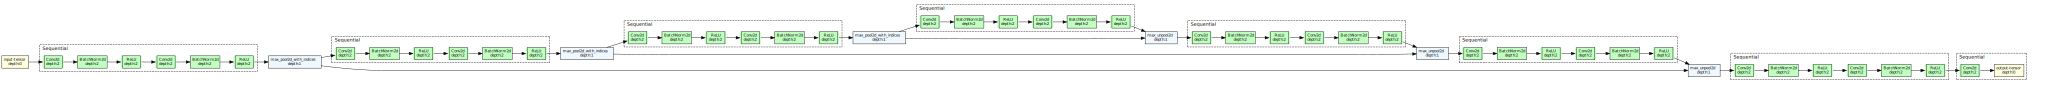

In [6]:
from torchview import draw_graph
# Code to visualize the model from https://github.com/mert-kurttutan/torchview

#model.eval()

batch_size = 8
C = 3  
H = TARGET_IMG_HEIGHT 
W = TARGET_IMG_WIDTH

model_graph = draw_graph(
    model,
    input_size=(batch_size, C, H, W), 
    device=torch.device('cuda'),
    expand_nested=True,
    show_shapes=False,
    graph_dir = "LR",
    save_graph = True,
)
model_graph.visual_graph

# Back to training mode
#model.train()

## Hyperparams and loss

In [7]:
def iou_coef_pytorch(y_true, y_pred, smooth=1.0):
    """
    Computes the IoU (Intersection over Union) coefficient for PyTorch.
    
    Args:
        y_true: Ground truth tensor (usually shaped [Batch, 1, H, W]) with float values in [0, 1].
        y_pred: Predicted tensor (same shape as y_true) with float values in [0, 1].
        smooth: Small constant to avoid division by zero.
    """
    
    # Flatten both tensors and ensure they are float
    y_true = y_true.view(-1).float()
    y_pred = y_pred.view(-1).float()
    
    # Compute Intersection and Union
    intersection = (y_true * y_pred).sum()
    union = y_true.sum() + y_pred.sum() - intersection
    
    # Return IoU coefficient with smoothing
    # Smoothing prevents division by zero when both y_true and y_pred are empty
    return (intersection + smooth) / (union + smooth)

# Loss Function: Dice Loss
class DiceLoss(nn.Module):
    """ Dice Loss is more sensitive to small regions, as the ones in our case """
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, y_pred, y_true):
        # sigmoid because not present in the last layer of the structure
        y_pred = torch.sigmoid(y_pred) 
        
        # Flatten tensors: (B, C, H, W) to (B*C*H*W)
        y_pred = y_pred.contiguous().view(-1)
        y_true = y_true.contiguous().view(-1)

        # Compute intersection and Dice coefficient
        # L'intersezione e le somme funzionano meglio se i target (y_true) sono float
        y_true = y_true.float() 
        
        intersection = (y_pred * y_true).sum()
        dice_coefficient = (2. * intersection + self.smooth) / \
                             (y_pred.sum() + y_true.sum() + self.smooth)
        
        # Dice Loss = 1 - Dice Coefficient
        return 1.0 - dice_coefficient

In [8]:
# Hyperparameters
BATCH_SIZE = 8
NUM_EPOCHS = 100
LEARNING_RATE = 1e-4  # Tipical Value

# Configuration
# Replace the standard BCE loss with Dice Loss
# loss_fn = nn.BCELoss()
loss_fn = DiceLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(f"Device used for training: {device}")

Device used for training: cuda


## Dataset Preparation

In [9]:
def load_split_metadata(jsonl_path, img_dir):
    """
    Load annotations from a JSONL file and check if the corresponding image 
    files exist (as we are using a small part of the whole dataset).
    Returns a list of metadata dictionaries instead of full NumPy arrays.
    """
       
    annos = read_jsonl(jsonl_path)
    if not os.path.isdir(img_dir):
        print(f"WARNING: Image directory not found: {img_dir}.")
        return []

    metadata_list = []
    
    # Build a metadata list with valid image paths and annotations
    for anno in annos:
        fname = anno.get("file_name")
        if fname and os.path.exists(os.path.join(img_dir, fname)):
            metadata_list.append({
                "file_path": os.path.join(img_dir, fname),
                "annotations": anno.get("annotations", []),
                "ignore": anno.get("ignore", [])
            })
            
    print(f"Caricamento {os.path.basename(jsonl_path)}: Trovate {len(metadata_list)} immagini valide.")
    return metadata_list
    
# These lines create the missing variables by loading metadata
train_metadata = load_split_metadata(TRAIN_JSONL, IMG_DIR)
val_metadata = load_split_metadata(os.path.join(BASE, "val.jsonl"), IMG_DIR)

print("Train metadata loaded:", len(train_metadata))
print("Validation metadata loaded:", len(val_metadata))

Caricamento train.jsonl: Trovate 845 immagini valide.
Caricamento val.jsonl: Trovate 155 immagini valide.
Train metadata loaded: 845
Validation metadata loaded: 155


In [10]:
# Usage of Dataset and Dataloader (with TARGET_IMG_HEIGHT/WIDTH)
train_dataset = ImageMaskDataset(train_metadata, target_h=TARGET_IMG_HEIGHT, target_w=TARGET_IMG_WIDTH)
val_dataset = ImageMaskDataset(val_metadata, target_h=TARGET_IMG_HEIGHT, target_w=TARGET_IMG_WIDTH)

# Increase number of workers for loading the data faster
NUM_WORKERS = os.cpu_count() // 2
if NUM_WORKERS == 0: NUM_WORKERS = 1 # at least 1

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

## Image with mask example

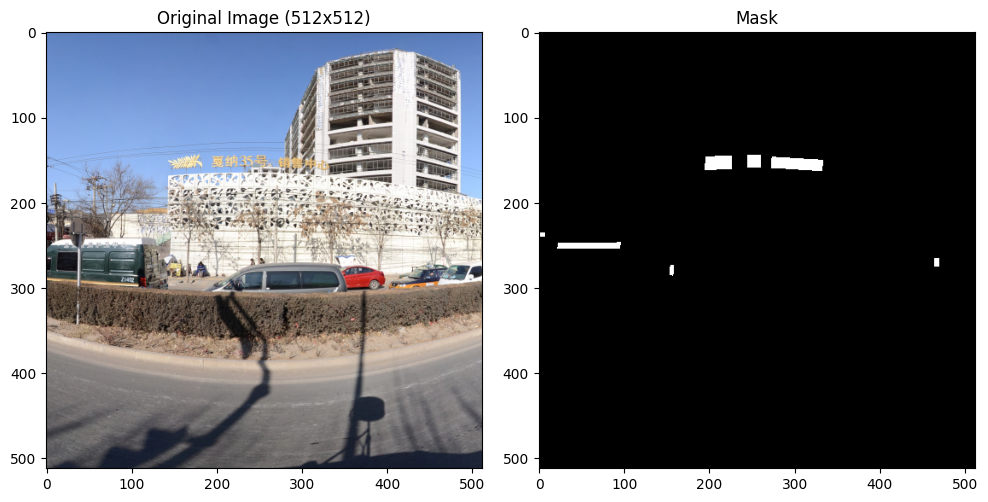

In [11]:
# Get a random item
# The function __getitem__ gives a PyTorch tensor (C, H, W)
image_random_idx = random.randint(0, len(train_dataset) - 1) 
image_tensor, mask_tensor = train_dataset[image_random_idx]

# From PyTorch (C, H, W) to NumPy/Matplotlib (H, W, C)
image_np = image_tensor.numpy().transpose(1, 2, 0)

# Mask: (1, H, W) -> (H, W). Float [0, 1]
mask_np = mask_tensor.numpy().squeeze()
# mask_np = mask_np.astype(bool) 

# Visualization
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Original Image
axs[0].imshow(image_np)
axs[0].set_title(f'Original Image ({image_np.shape[0]}x{image_np.shape[1]})')
axs[0].axis('on')

# Mask
axs[1].imshow(mask_np, cmap='gray')
axs[1].set_title('Mask')
axs[1].axis('on')

plt.tight_layout()
plt.savefig("plot.png")
plt.show()

## TRAINING

In [12]:
# Metric containers
train_losses = []
val_losses = []
val_iou = []

best_iou = 0.0
for epoch in range(1, NUM_EPOCHS + 1):
    start_time = time.time()
    
    # TRAINING PHASE
    model.train() # Enable training mode (activates Dropout, etc...)
    total_train_loss = 0.0
    
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch}/{NUM_EPOCHS} (Train)")):
        
        # Move inputs/targets to device
        data, targets = data.to(device), targets.to(device)

        # 1) Forward pass
        predictions = model(data)
        
        # 2) Compute loss
        # Targets shape must match predictions shape
        loss = loss_fn(predictions, targets)
        
        # 3) Backpropagation and optimizer step
        optimizer.zero_grad() # reset accumulated grads
        loss.backward()       # compute parameter gradients
        optimizer.step()      # update parameters (weights)

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # VALIDATION PHASE
    model.eval() # Evaluation mode (disables Dropout, etc...)
    total_val_loss = 0.0
    total_val_iou = 0.0
    
    with torch.no_grad(): # no gradient tracking and computation in validation
        for data, targets in tqdm(val_loader, desc="           (Val)"):
            data, targets = data.to(device), targets.to(device)
            
            predictions = model(data)
            
            # Loss on validation batch
            loss = loss_fn(predictions, targets)
            total_val_loss += loss.item()
            
            # IoU metric:
            # Use a binarized prediction for final IoU (threshold 0.5).
            iou = iou_coef_pytorch(targets, (predictions > 0.5).float())
            total_val_iou += iou.item()

    avg_val_loss = total_val_loss / len(val_loader)
    avg_val_iou = total_val_iou / len(val_loader)
    val_losses.append(avg_val_loss)
    val_iou.append(avg_val_iou)
    
    end_time = time.time()
    
    # Log epoch summary (Keras-style)
    print(f"\nEpoch {epoch}/{NUM_EPOCHS} - {int(end_time - start_time)}s/epoch - train_iou:  - loss: {avg_train_loss:.4f} - val_loss: {avg_val_loss:.4f} - val_iou: {avg_val_iou:.4f}")
    
    # CHECKPOINTING: save best model by val IoU
    if avg_val_iou > best_iou:
        best_iou = avg_val_iou
        torch.save(model, 'best_segnet_model.pth')
        print("SAVED!")

           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.15it/s]



Epoch 1/100 - 17s/epoch - train_iou:  - loss: 0.9815 - val_loss: 0.9739 - val_iou: 0.0229
SAVED!


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.16it/s]



Epoch 2/100 - 16s/epoch - train_iou:  - loss: 0.9711 - val_loss: 0.9645 - val_iou: 0.0586
SAVED!


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.90it/s]



Epoch 3/100 - 16s/epoch - train_iou:  - loss: 0.9594 - val_loss: 0.9542 - val_iou: 0.0729
SAVED!


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.11it/s]



Epoch 4/100 - 16s/epoch - train_iou:  - loss: 0.9419 - val_loss: 0.9257 - val_iou: 0.1460
SAVED!


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.41it/s]



Epoch 5/100 - 16s/epoch - train_iou:  - loss: 0.9114 - val_loss: 0.8977 - val_iou: 0.1281


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.15it/s]



Epoch 6/100 - 16s/epoch - train_iou:  - loss: 0.8656 - val_loss: 0.8250 - val_iou: 0.2062
SAVED!


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.31it/s]



Epoch 7/100 - 16s/epoch - train_iou:  - loss: 0.7856 - val_loss: 0.8473 - val_iou: 0.1071


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.21it/s]



Epoch 8/100 - 17s/epoch - train_iou:  - loss: 0.6379 - val_loss: 0.8455 - val_iou: 0.0951


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.46it/s]



Epoch 9/100 - 16s/epoch - train_iou:  - loss: 0.5414 - val_loss: 0.6788 - val_iou: 0.2136
SAVED!


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.04it/s]



Epoch 10/100 - 16s/epoch - train_iou:  - loss: 0.4941 - val_loss: 0.5924 - val_iou: 0.2764
SAVED!


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.96it/s]



Epoch 11/100 - 16s/epoch - train_iou:  - loss: 0.4503 - val_loss: 0.5904 - val_iou: 0.2733


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.07it/s]



Epoch 12/100 - 16s/epoch - train_iou:  - loss: 0.4292 - val_loss: 0.6576 - val_iou: 0.2184


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.01it/s]



Epoch 13/100 - 16s/epoch - train_iou:  - loss: 0.4117 - val_loss: 0.5785 - val_iou: 0.2799
SAVED!


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.23it/s]



Epoch 14/100 - 16s/epoch - train_iou:  - loss: 0.3893 - val_loss: 0.5855 - val_iou: 0.2732


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.23it/s]



Epoch 15/100 - 16s/epoch - train_iou:  - loss: 0.3726 - val_loss: 0.5599 - val_iou: 0.2940
SAVED!


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.58it/s]



Epoch 16/100 - 16s/epoch - train_iou:  - loss: 0.3456 - val_loss: 0.5951 - val_iou: 0.2642


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.40it/s]



Epoch 17/100 - 16s/epoch - train_iou:  - loss: 0.3545 - val_loss: 0.6181 - val_iou: 0.2433


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.13it/s]



Epoch 18/100 - 16s/epoch - train_iou:  - loss: 0.3321 - val_loss: 0.6589 - val_iou: 0.2125


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.59it/s]



Epoch 19/100 - 16s/epoch - train_iou:  - loss: 0.3264 - val_loss: 0.6069 - val_iou: 0.2536


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.79it/s]



Epoch 20/100 - 16s/epoch - train_iou:  - loss: 0.3169 - val_loss: 0.5645 - val_iou: 0.2877


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.03it/s]



Epoch 21/100 - 16s/epoch - train_iou:  - loss: 0.3115 - val_loss: 0.5481 - val_iou: 0.3008
SAVED!


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.11it/s]



Epoch 22/100 - 16s/epoch - train_iou:  - loss: 0.2998 - val_loss: 0.5492 - val_iou: 0.2990


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.88it/s]



Epoch 23/100 - 16s/epoch - train_iou:  - loss: 0.2934 - val_loss: 0.5664 - val_iou: 0.2845


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.49it/s]



Epoch 24/100 - 16s/epoch - train_iou:  - loss: 0.2847 - val_loss: 0.5331 - val_iou: 0.3133
SAVED!


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.09it/s]



Epoch 25/100 - 16s/epoch - train_iou:  - loss: 0.2806 - val_loss: 0.6220 - val_iou: 0.2395


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.85it/s]



Epoch 26/100 - 16s/epoch - train_iou:  - loss: 0.2754 - val_loss: 0.5883 - val_iou: 0.2674


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.83it/s]



Epoch 27/100 - 16s/epoch - train_iou:  - loss: 0.2706 - val_loss: 0.5446 - val_iou: 0.3031


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.15it/s]



Epoch 28/100 - 17s/epoch - train_iou:  - loss: 0.2637 - val_loss: 0.5952 - val_iou: 0.2605


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.03it/s]



Epoch 29/100 - 17s/epoch - train_iou:  - loss: 0.2634 - val_loss: 0.5572 - val_iou: 0.2920


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.53it/s]



Epoch 30/100 - 16s/epoch - train_iou:  - loss: 0.2579 - val_loss: 0.6113 - val_iou: 0.2483


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.27it/s]



Epoch 31/100 - 16s/epoch - train_iou:  - loss: 0.2617 - val_loss: 0.5719 - val_iou: 0.2801


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.60it/s]



Epoch 32/100 - 16s/epoch - train_iou:  - loss: 0.2566 - val_loss: 0.5451 - val_iou: 0.3014


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.96it/s]



Epoch 33/100 - 16s/epoch - train_iou:  - loss: 0.2485 - val_loss: 0.5666 - val_iou: 0.2851


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.13it/s]



Epoch 34/100 - 17s/epoch - train_iou:  - loss: 0.2446 - val_loss: 0.5352 - val_iou: 0.3097


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.83it/s]



Epoch 35/100 - 16s/epoch - train_iou:  - loss: 0.2393 - val_loss: 0.5447 - val_iou: 0.3029


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.11it/s]



Epoch 36/100 - 17s/epoch - train_iou:  - loss: 0.2333 - val_loss: 0.5595 - val_iou: 0.2897


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.35it/s]



Epoch 37/100 - 16s/epoch - train_iou:  - loss: 0.2357 - val_loss: 0.5881 - val_iou: 0.2669


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.94it/s]



Epoch 38/100 - 16s/epoch - train_iou:  - loss: 0.2322 - val_loss: 0.5412 - val_iou: 0.3064


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.93it/s]



Epoch 39/100 - 16s/epoch - train_iou:  - loss: 0.2336 - val_loss: 0.5363 - val_iou: 0.3100


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.70it/s]



Epoch 40/100 - 16s/epoch - train_iou:  - loss: 0.2279 - val_loss: 0.5612 - val_iou: 0.2890


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.91it/s]



Epoch 41/100 - 16s/epoch - train_iou:  - loss: 0.2233 - val_loss: 0.5580 - val_iou: 0.2914


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.04it/s]



Epoch 42/100 - 16s/epoch - train_iou:  - loss: 0.2210 - val_loss: 0.5861 - val_iou: 0.2684


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.76it/s]



Epoch 43/100 - 16s/epoch - train_iou:  - loss: 0.2173 - val_loss: 0.5546 - val_iou: 0.2941


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.97it/s]



Epoch 44/100 - 17s/epoch - train_iou:  - loss: 0.2226 - val_loss: 0.5339 - val_iou: 0.3119


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.88it/s]



Epoch 45/100 - 16s/epoch - train_iou:  - loss: 0.2165 - val_loss: 0.6006 - val_iou: 0.2567


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.77it/s]



Epoch 46/100 - 16s/epoch - train_iou:  - loss: 0.2127 - val_loss: 0.6001 - val_iou: 0.2570


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.31it/s]



Epoch 47/100 - 16s/epoch - train_iou:  - loss: 0.2107 - val_loss: 0.5667 - val_iou: 0.2837


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.96it/s]



Epoch 48/100 - 16s/epoch - train_iou:  - loss: 0.2117 - val_loss: 0.5479 - val_iou: 0.2992


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.85it/s]



Epoch 49/100 - 16s/epoch - train_iou:  - loss: 0.2094 - val_loss: 0.5504 - val_iou: 0.2978


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.82it/s]



Epoch 50/100 - 16s/epoch - train_iou:  - loss: 0.2020 - val_loss: 0.6013 - val_iou: 0.2563


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.58it/s]



Epoch 51/100 - 17s/epoch - train_iou:  - loss: 0.2033 - val_loss: 0.5474 - val_iou: 0.2998


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.99it/s]



Epoch 52/100 - 16s/epoch - train_iou:  - loss: 0.2019 - val_loss: 0.5678 - val_iou: 0.2831


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.51it/s]



Epoch 53/100 - 17s/epoch - train_iou:  - loss: 0.2040 - val_loss: 0.5685 - val_iou: 0.2815


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.03it/s]



Epoch 54/100 - 16s/epoch - train_iou:  - loss: 0.2047 - val_loss: 0.5690 - val_iou: 0.2820


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.74it/s]



Epoch 55/100 - 16s/epoch - train_iou:  - loss: 0.1933 - val_loss: 0.5520 - val_iou: 0.2965


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.69it/s]



Epoch 56/100 - 16s/epoch - train_iou:  - loss: 0.1928 - val_loss: 0.5589 - val_iou: 0.2906


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.14it/s]



Epoch 57/100 - 16s/epoch - train_iou:  - loss: 0.1910 - val_loss: 0.5692 - val_iou: 0.2820


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.96it/s]



Epoch 58/100 - 17s/epoch - train_iou:  - loss: 0.1898 - val_loss: 0.5576 - val_iou: 0.2920


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.07it/s]



Epoch 59/100 - 16s/epoch - train_iou:  - loss: 0.1896 - val_loss: 0.5472 - val_iou: 0.2998


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.74it/s]



Epoch 60/100 - 16s/epoch - train_iou:  - loss: 0.1925 - val_loss: 0.5553 - val_iou: 0.2932


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.62it/s]



Epoch 61/100 - 16s/epoch - train_iou:  - loss: 0.1889 - val_loss: 0.5564 - val_iou: 0.2930


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.95it/s]



Epoch 62/100 - 16s/epoch - train_iou:  - loss: 0.1869 - val_loss: 0.5672 - val_iou: 0.2839


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.21it/s]



Epoch 63/100 - 17s/epoch - train_iou:  - loss: 0.1819 - val_loss: 0.5723 - val_iou: 0.2806


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.18it/s]



Epoch 64/100 - 17s/epoch - train_iou:  - loss: 0.1863 - val_loss: 0.5733 - val_iou: 0.2787


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.12it/s]



Epoch 65/100 - 16s/epoch - train_iou:  - loss: 0.1820 - val_loss: 0.5696 - val_iou: 0.2819


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.64it/s]



Epoch 66/100 - 16s/epoch - train_iou:  - loss: 0.1790 - val_loss: 0.5585 - val_iou: 0.2908


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.40it/s]



Epoch 67/100 - 16s/epoch - train_iou:  - loss: 0.1787 - val_loss: 0.5430 - val_iou: 0.3041


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.03it/s]



Epoch 68/100 - 16s/epoch - train_iou:  - loss: 0.1832 - val_loss: 0.5654 - val_iou: 0.2855


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.07it/s]



Epoch 69/100 - 16s/epoch - train_iou:  - loss: 0.1765 - val_loss: 0.5541 - val_iou: 0.2944


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.61it/s]



Epoch 70/100 - 16s/epoch - train_iou:  - loss: 0.1771 - val_loss: 0.5496 - val_iou: 0.2992


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.96it/s]



Epoch 71/100 - 16s/epoch - train_iou:  - loss: 0.1762 - val_loss: 0.5582 - val_iou: 0.2920


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.17it/s]



Epoch 72/100 - 16s/epoch - train_iou:  - loss: 0.1760 - val_loss: 0.5805 - val_iou: 0.2740


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.90it/s]



Epoch 73/100 - 17s/epoch - train_iou:  - loss: 0.1778 - val_loss: 0.5618 - val_iou: 0.2884


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.89it/s]



Epoch 74/100 - 16s/epoch - train_iou:  - loss: 0.1728 - val_loss: 0.5833 - val_iou: 0.2703


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.21it/s]



Epoch 75/100 - 16s/epoch - train_iou:  - loss: 0.1685 - val_loss: 0.5799 - val_iou: 0.2740


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.13it/s]



Epoch 76/100 - 16s/epoch - train_iou:  - loss: 0.1710 - val_loss: 0.5903 - val_iou: 0.2663


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.47it/s]



Epoch 77/100 - 16s/epoch - train_iou:  - loss: 0.1758 - val_loss: 0.6021 - val_iou: 0.2566


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.97it/s]



Epoch 78/100 - 17s/epoch - train_iou:  - loss: 0.1741 - val_loss: 0.5422 - val_iou: 0.3050


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.73it/s]



Epoch 79/100 - 16s/epoch - train_iou:  - loss: 0.1686 - val_loss: 0.5806 - val_iou: 0.2746


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.83it/s]



Epoch 80/100 - 16s/epoch - train_iou:  - loss: 0.1661 - val_loss: 0.5513 - val_iou: 0.2975


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.78it/s]



Epoch 81/100 - 17s/epoch - train_iou:  - loss: 0.1662 - val_loss: 0.5510 - val_iou: 0.2977


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.02it/s]



Epoch 82/100 - 17s/epoch - train_iou:  - loss: 0.1659 - val_loss: 0.5671 - val_iou: 0.2841


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.86it/s]



Epoch 83/100 - 16s/epoch - train_iou:  - loss: 0.1683 - val_loss: 0.5473 - val_iou: 0.3000


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.21it/s]



Epoch 84/100 - 16s/epoch - train_iou:  - loss: 0.1638 - val_loss: 0.5705 - val_iou: 0.2809


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.04it/s]



Epoch 85/100 - 16s/epoch - train_iou:  - loss: 0.1623 - val_loss: 0.5852 - val_iou: 0.2693


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.78it/s]



Epoch 86/100 - 16s/epoch - train_iou:  - loss: 0.1599 - val_loss: 0.5489 - val_iou: 0.2989


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.92it/s]



Epoch 87/100 - 17s/epoch - train_iou:  - loss: 0.1601 - val_loss: 0.5625 - val_iou: 0.2875


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.51it/s]



Epoch 88/100 - 16s/epoch - train_iou:  - loss: 0.1591 - val_loss: 0.5775 - val_iou: 0.2762


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.95it/s]



Epoch 89/100 - 16s/epoch - train_iou:  - loss: 0.1595 - val_loss: 0.5476 - val_iou: 0.3001


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.06it/s]



Epoch 90/100 - 16s/epoch - train_iou:  - loss: 0.1647 - val_loss: 0.5556 - val_iou: 0.2940


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.66it/s]



Epoch 91/100 - 16s/epoch - train_iou:  - loss: 0.1591 - val_loss: 0.5480 - val_iou: 0.2996


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.79it/s]



Epoch 92/100 - 16s/epoch - train_iou:  - loss: 0.1600 - val_loss: 0.5686 - val_iou: 0.2829


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.09it/s]



Epoch 93/100 - 16s/epoch - train_iou:  - loss: 0.1574 - val_loss: 0.5800 - val_iou: 0.2746


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.05it/s]



Epoch 94/100 - 16s/epoch - train_iou:  - loss: 0.1585 - val_loss: 0.5690 - val_iou: 0.2830


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.08it/s]



Epoch 95/100 - 17s/epoch - train_iou:  - loss: 0.1568 - val_loss: 0.5469 - val_iou: 0.3007


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.07it/s]



Epoch 96/100 - 16s/epoch - train_iou:  - loss: 0.1529 - val_loss: 0.5661 - val_iou: 0.2849


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.22it/s]



Epoch 97/100 - 16s/epoch - train_iou:  - loss: 0.1543 - val_loss: 0.5469 - val_iou: 0.3003


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.88it/s]



Epoch 98/100 - 16s/epoch - train_iou:  - loss: 0.1541 - val_loss: 0.5850 - val_iou: 0.2697


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.88it/s]



Epoch 99/100 - 16s/epoch - train_iou:  - loss: 0.1520 - val_loss: 0.5518 - val_iou: 0.2964


           (Val): 100%|█████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.74it/s]


Epoch 100/100 - 17s/epoch - train_iou:  - loss: 0.1496 - val_loss: 0.5642 - val_iou: 0.2863


## Visual test with loading of the model

In [13]:
MODEL_PATH = 'best_segnet_model.pth'

try:
    segnet_model = SimpleSegNet(in_channels=3, out_channels=1) 
except NameError:
    print("ERROR: you have to execute the block of the definition of SimpleSegNet")
    raise

# Weights load
segnet_model = torch.load(MODEL_PATH, map_location=device, weights_only=False)

segnet_model.to(device)
segnet_model.eval() 

SimpleSegNet(
  (enc1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track

## Random image from the validation set with predicted mask and overlay

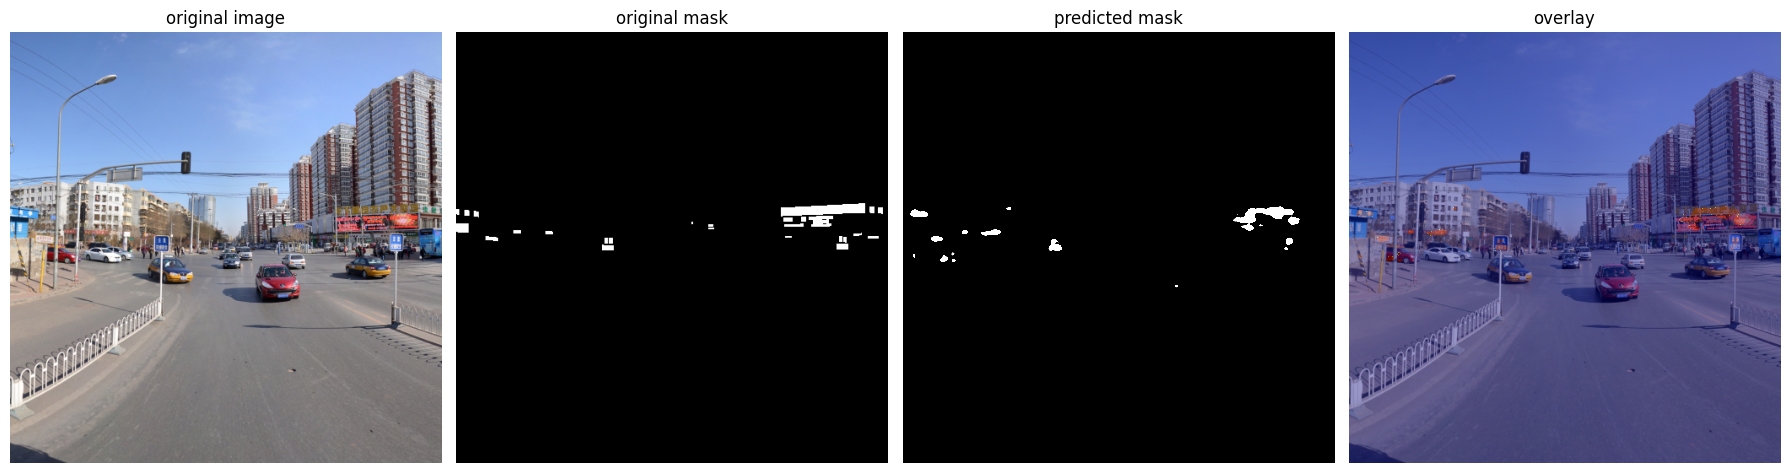

In [16]:
# Pick a random index from the validation set
ind = random.randint(0, len(val_dataset) - 1)

# Extract an item from the dataset (returns tensors: C, H, W)
img_tensor, gt_tensor = val_dataset[ind] 

# Move tensor to device (GPU/CPU) for prediction
# PyTorch expects a batch, so we add a batch dimension: (1, C, H, W)
img_batch = img_tensor.unsqueeze(0).to(device)

# Model Prediction (Manual Forward Pass)
segnet_model.eval() # Evaluation mode (disables dropout, etc.)
with torch.no_grad():
    pred_tensor = segnet_model(img_batch) 

# Convert tensors to NumPy for Matplotlib visualization
# Original image: (C, H, W) -> (H, W, C)
img_np = img_tensor.cpu().numpy().transpose(1, 2, 0)

# Ground Truth: (1, H, W) -> (H, W) float in [0, 1]
gt_vis = gt_tensor.cpu().numpy().squeeze() 

# Prediction
pred_vis = pred_tensor.cpu().numpy().squeeze() 

# Plot
plt.figure(figsize=(18, 5))

# Subplot 1: Original Image
plt.subplot(1, 4, 1)
plt.title("original image")
plt.axis('off')
plt.imshow(img_np) # Already normalized [0, 1]

# Subplot 2: Ground Truth Mask
plt.subplot(1, 4, 2)
plt.title("original mask")
plt.axis('off')
plt.imshow(gt_vis, cmap='gray', vmin=0, vmax=1)

# Subplot 3: Predicted Mask (Soft Prediction)
plt.subplot(1, 4, 3)
plt.title("predicted mask")
plt.axis('off')
plt.imshow(pred_vis, cmap='gray', vmin=0, vmax=1)

# Subplot 4: Overlay (Image + Predicted Mask)
plt.subplot(1, 4, 4)
plt.title("overlay")
plt.axis('off')
plt.imshow(img_np)
# Overlay prediction with a colormap and transparency
plt.imshow(pred_vis, cmap='jet', alpha=0.4, vmin=0, vmax=1)

plt.savefig("segnet_ex.png")
plt.tight_layout()
plt.show()